In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from pathlib import Path
import matplotlib.pyplot as plt


In [3]:
data = Path(r"D:\cells")

In [4]:
# Count number of items in each subdirectory of the folder
from collections import Counter

dir_counts = {subdir.name: len(list(subdir.iterdir())) for subdir in data.iterdir() if subdir.is_dir()}
print(dir_counts)

{'cancerous': 7272, 'healthy': 3389}


In [ ]:
# Balance dataset: 5k per class, augment healthy to 5k, sample cancerous to 5k
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import random
import os

healthy_dir = data / 'healthy'
cancerous_dir = data / 'cancerous'

healthy_imgs = list(healthy_dir.glob('*'))
cancerous_imgs = list(cancerous_dir.glob('*'))

# For healthy: augment to reach 5k
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
healthy_augmented = []
for img_path in healthy_imgs:
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    # Generate 1 augmented image per original (if needed)
    for batch in aug.flow(x, batch_size=1):
        healthy_augmented.append(batch[0])
        if len(healthy_augmented) >= 2000:
            break
    if len(healthy_augmented) >= 2000:
        break

healthy_final = healthy_imgs + [array_to_img(x) for x in healthy_augmented]
healthy_final = healthy_final[:5000] 

# For cancerous: randomly sample 5k
cancerous_final = random.sample(cancerous_imgs, 5000) if len(cancerous_imgs) > 5000 else cancerous_imgs

print(f'Healthy images: {len(healthy_final)}')
print(f'Cancerous images: {len(cancerous_final)}')

Healthy images: 5000
Cancerous images: 5000


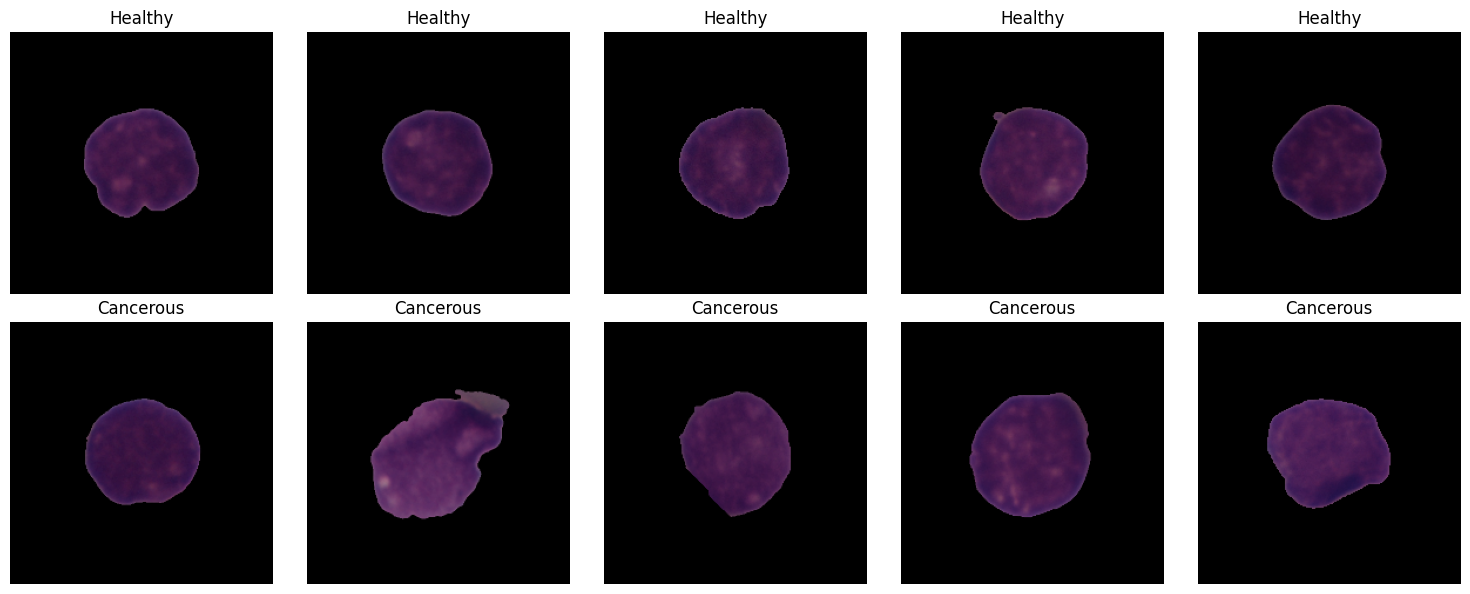

In [9]:
# Plot sample images from both classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    img = load_img(healthy_final[i], target_size=(224,224))
    axes[0, i].imshow(img)
    axes[0, i].set_title('Healthy')
    axes[0, i].axis('off')
for i in range(5):
    img = load_img(cancerous_final[i], target_size=(224,224))
    axes[1, i].imshow(img)
    axes[1, i].set_title('Cancerous')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Split into train (70%), val (15%), test (15%)
from sklearn.model_selection import train_test_split
all_imgs = healthy_final + cancerous_final
all_labels = [0]*len(healthy_final) + [1]*len(cancerous_final)

In [12]:
# Split into train, val, test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_imgs, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Train: 7000, Val: 1500, Test: 1500


In [17]:
# Data generator for model input
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np

class ImageSequence(Sequence):
    def __init__(self, img_paths, labels, batch_size=32, augment=False):
        self.img_paths = img_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=15,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          horizontal_flip=True) if augment else ImageDataGenerator(rescale=1./255)

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        images = [
            img_to_array(load_img(img, target_size=(224,224))) if isinstance(img, (str, Path))
            else img_to_array(img.resize((224,224)))
            for img in batch_x
        ]
        images = np.array(images)
        images = self.datagen.standardize(images)
        labels = to_categorical(batch_y, num_classes=2)
        return images, labels

In [52]:
# Create generators for training, validation, and test sets
BATCH_SIZE = 32
train_gen = ImageSequence(X_train[:750], y_train[:750], batch_size=BATCH_SIZE, augment=True)
val_gen = ImageSequence(X_val[:50], y_val[:50], batch_size=BATCH_SIZE, augment=False)
test_gen = ImageSequence(X_test[:50], y_test[:50], batch_size=BATCH_SIZE, augment=False)

In [53]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(95, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax') 
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
 )

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 95)     │        54,815 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 95)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64220)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     8,220,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,294,753 (31.64 MB)

 Trainable params: 8,294,753 (31.64 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3
)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 988ms/step - accuracy: 0.7303 - loss: 0.5565 - val_accuracy: 0.8600 - val_loss: 0.3480
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 988ms/step - accuracy: 0.7303 - loss: 0.5565 - val_accuracy: 0.8600 - val_loss: 0.3480
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 960ms/step - accuracy: 0.8297 - loss: 0.4066 - val_accuracy: 0.9000 - val_loss: 0.3778
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 960ms/step - accuracy: 0.8297 - loss: 0.4066 - val_accuracy: 0.9000 - val_loss: 0.3778
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 958ms/step - accuracy: 0.8330 - loss: 0.3873 - val_accuracy: 0.8800 - val_loss: 0.3629
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 958ms/step - accuracy: 0.8330 - loss: 0.3873 - val_accuracy: 0.8800 - val_loss: 0.3629


In [55]:
len(X_train[:750])

750

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

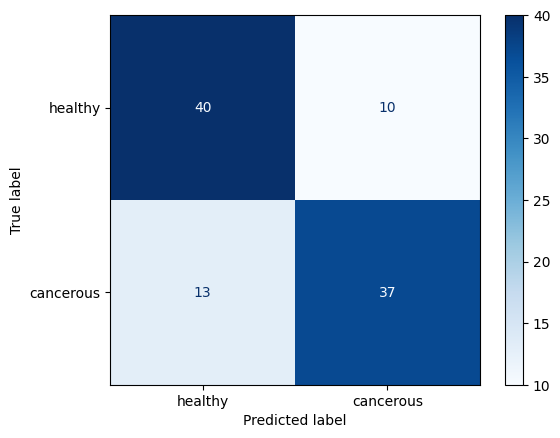

In [57]:
# Plot confusion matrix for test set predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
y_true = np.array(y_test)
y_pred = []
for i in range(len(X_test)):
    img = X_test[i]
    if isinstance(img, (str, Path)):
        im = load_img(img, target_size=(224,224))
    else:
        im = img.resize((224,224))
    x = img_to_array(im) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    y_pred.append(np.argmax(pred, axis=1)[0])

# Confusion matrix
cm = confusion_matrix(y_true[:100], y_pred[:100])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy', 'cancerous'])
disp.plot(cmap='Blues')
plt.show()

In [44]:
# Function to preprocess and predict class for a single image
def predict_image(img_path, model):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    # Preprocess image
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    # Predict
    pred = model.predict(x)
    class_idx = np.argmax(pred, axis=1)[0]
    class_name = 'healthy cell' if class_idx == 0 else 'cancer cell'
    print(f'Predicted class: {class_name} (prob={pred[0][class_idx]:.4f})')
    return class_name

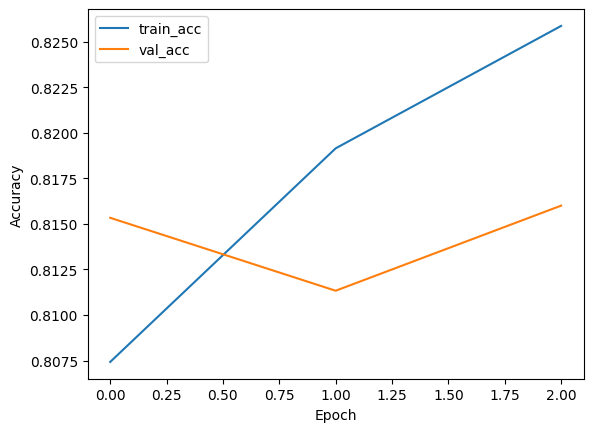

In [21]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [45]:
predict_image(r'D:\cells\healthy\UID_H2_29_1_hem.bmp', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: healthy cell (prob=0.7522)
Predicted class: healthy cell (prob=0.7522)


'healthy cell'

In [ ]:
# Save healthy_final and cancerous_final images to output folders
import os
from PIL import Image
output_dir = 'output_dataset'
healthy_out = os.path.join(output_dir, 'healthy')
cancer_out = os.path.join(output_dir, 'cancerous')
os.makedirs(healthy_out, exist_ok=True)
os.makedirs(cancer_out, exist_ok=True)

# Save healthy images
for i, img in enumerate(healthy_final):
    if isinstance(img, (str, Path)):
        im = Image.open(img)
    else:
        im = img
    im.save(os.path.join(healthy_out, f'healthy_{i}.png'))

# Save cancerous images
for i, img in enumerate(cancerous_final):
    if isinstance(img, (str, Path)):
        im = Image.open(img)
    else:
        im = img
    im.save(os.path.join(cancer_out, f'cancerous_{i}.png'))

print('Images saved to output_dataset/healthy and output_dataset/cancerous')